# Data Description
In this 1st exercise on feature engineering with time series data, you will practice data transformation with the [`weather dataset`](https://www.bgc-jena.mpg.de/wetter/) recorded by the [Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/). 

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. 

These were collected every 10 minutes, beginning in 2003. For this lab, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book *Deep Learning with Python*.

The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

You will perform data preprocessing so that the features can be used to train an LSTM using TensorFlow and Keras downstream. You will not be asked to train a model as the focus is on feature preprocessing. However in later courses of this specialization, you will get to learn more about time series forecasting, at which point you can retreive your saved tfrecords and train a neural net model for weather forecasting.

Upon completion, you will have

* Explored and visualized the weather time series dataset and declared its schema
* Transformed the data for modeling using TF Transform
* Prepared Training Dataset Windows from `TFTransformOutput`

In [1]:
!pip install tensorflow==2.4.0 tfx==0.27.0 tensorflow_addons==0.12.1 fsspec==0.8.7

     |████████████████████████████████| 394.7 MB 15 kB/s 
     |████████████████████████████████| 2.3 MB 37.4 MB/s 
     |████████████████████████████████| 703 kB 40.4 MB/s 
     |████████████████████████████████| 2.9 MB 24.4 MB/s 
     |████████████████████████████████| 462 kB 36.1 MB/s 
     |████████████████████████████████| 3.8 MB 43.3 MB/s 
     |████████████████████████████████| 17.7 MB 73 kB/s 
     |████████████████████████████████| 147 kB 58.0 MB/s 
     |████████████████████████████████| 9.8 MB 49.0 MB/s 
     |████████████████████████████████| 2.9 MB 28.1 MB/s 
     |████████████████████████████████| 92 kB 411 kB/s 
     |████████████████████████████████| 1.3 MB 36.2 MB/s 
     |████████████████████████████████| 103 kB 42.5 MB/s 
     |████████████████████████████████| 1.5 MB 39.8 MB/s 
     |████████████████████████████████| 1.1 MB 46.7 MB/s 
     |████████████████████████████████| 127 kB 43.9 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |█████████████

In [1]:
import tfx

In [2]:
!pip install 'fsspec==0.8.7'

     |████████████████████████████████| 103 kB 6.5 MB/s 


# Import packages

In [3]:
import os 
import pprint 
import tempfile
import urllib
import pandas as pd 
import numpy as np 

import absl
import tensorflow as tf  
tf.get_logger().propagate = False
pp = pprint.PrettyPrinter()

import tfx
from tfx.components import CsvExampleGen 
from tfx.components import ExampleValidator
from tfx.components import SchemaGen
from tfx.components import StatisticsGen 
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext 
from tfx.types import Channel 
from tfx.components import Transform
import dask.dataframe as dd

from google.protobuf.json_format import MessageToDict 

print(f'TFX version: {tfx.__version__}')
print(f'Tensorflow version: {tf.__version__}')


TFX version: 0.27.0
Tensorflow version: 2.4.0


# Setup datast and directories

In [4]:
# create pipeline directory
!mkdir -p pipeline

# create data directory
!mkdir -p data/climate

# Location of the pipeline metadata store
_pipeline_root = 'pipeline'

# Directory of raw data files
_data_root = 'data/climate'

# Path to the training data 
_data_filepath = os.path.join(_data_root, 'jena_climate_2009_2016.csv')

In [6]:
# Download the dataset.
!wget -nc https://raw.githubusercontent.com/https-deeplearning-ai/MLEP-public/main/course2/week4-ungraded-lab/data/jena_climate_2009_2016.csv -P {_data_root}

--2021-10-05 15:47:13--  https://raw.githubusercontent.com/https-deeplearning-ai/MLEP-public/main/course2/week4-ungraded-lab/data/jena_climate_2009_2016.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43164220 (41M) [text/plain]
Saving to: ‘data/climate/jena_climate_2009_2016.csv’

jena_climate_2009_2 100%[===================>]  41.16M   165MB/s    in 0.2s    

2021-10-05 15:47:15 (165 MB/s) - ‘data/climate/jena_climate_2009_2016.csv’ saved [43164220/43164220]



In [7]:
# Preview the dataset
!head {_data_filepath}

"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.60
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.00
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.30
01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.70
01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.80,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.50
01.01.2009 01:20:00,996.50,-7.62,265.81,-8.36,94.40,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,

You will also notice that there are quotes in the column names. It is up to you if you should keep it but for this exercise, it would be better to remove it so we don't have to factor it in when we're declaring the keys in the Transform module. Let's do that below.

In [8]:
# load the csv into a dataframe
df = dd.read_csv(_data_filepath)

# Remove the quotes in the column names
df.columns = df.columns.str.replace('"', '')

# save the changes
df.to_csv(_data_filepath+'_new', index=False) 

#see the results
!head {_data_filepath+'_new/*'}

Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
01.01.2009 00:10:00,996.52,-8.02,265.4,-8.9,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.8,0.72,1.5,136.1
01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.2,1.88,3.02,1310.24,0.19,0.63,171.6
01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.5,198.0
01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.0,0.32,0.63,214.3
01.01.2009 01:00:00,996.5,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
01.01.2009 01:10:00,996.5,-7.62,265.81,-8.3,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
01.01.2009 01:20:00,996.5,-7.62,265.81,-8.36,94.4,3.44,3.25,0.19,2.03,3.26,1305.69,0.19,0.5,118.6
01.01.2009 01:30:00,996.5,-7.91,265.52,-8.73,9

# Create the Interactive Context

In [9]:
# Initialize the interactiveContext 

context = InteractiveContext(pipeline_root=_pipeline_root)

# Example Gen

In [10]:
example_gen = CsvExampleGen(input_base=_data_filepath+'_new')
context.run(example_gen)

ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 1
    outputs:
        examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 1
        type_id: 5
        uri: "pipeline/CsvExampleGen/examples/1"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "input_fingerprint"
          value {
            string_value: "split:single_split,num_files:1,total_bytes:41987089,xor_checksum:1633448893,sum_checksum:1633448893"
          }
        }
        custom_properties {
          key: "payload_format"
          value {
            string_value: "FORMAT_TF_EXAMPLE"
          }
        }
        custom_properties {
          key: "span"
          value {
            string_value: "0"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

# StatisticsGen

In [11]:
# Instantiate StatisticsGen with the ExampleGen ingested dataset  
statistics_gen = StatisticsGen(
    examples= example_gen.outputs['examples']
)
context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: Channel(
            type_name: ExampleStatistics
            artifacts: [Artifact(artifact: id: 2
        type_id: 7
        uri: "pipeline/StatisticsGen/statistics/2"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "statistics"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "StatisticsGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 7
        name: "ExampleStatistics"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [12]:
# show the output statistics
context.show(statistics_gen.outputs['statistics'])

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


From the charts above, you might notice that the minimum value for wv (m/s) is -9999. Those are pretty intense winds and based on the other data points, this just looks like a faulty measurement.

# SchemaGen

In [13]:
schema_gen = SchemaGen(
    statistics=statistics_gen.outputs['statistics']
)

context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 3
    outputs:
        schema: Channel(
            type_name: Schema
            artifacts: [Artifact(artifact: id: 3
        type_id: 9
        uri: "pipeline/SchemaGen/schema/3"
        custom_properties {
          key: "name"
          value {
            string_value: "schema"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "SchemaGen"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 9
        name: "Schema"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [14]:
# Visualise the schema
context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'Date Time',BYTES,required,,-
'H2OC (mmol/mol)',FLOAT,required,,-
'T (degC)',FLOAT,required,,-
'Tdew (degC)',FLOAT,required,,-
'Tpot (K)',FLOAT,required,,-
'VPact (mbar)',FLOAT,required,,-
'VPdef (mbar)',FLOAT,required,,-
'VPmax (mbar)',FLOAT,required,,-
'max. wv (m/s)',FLOAT,required,,-


# ExampleValidator

Let's check for anomalies to ensure our data conforms to the schema

In [15]:
example_validator = ExampleValidator(
    statistics=statistics_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema']
)

context.run(example_validator)

context.show(example_validator.outputs['anomalies'])

# Transform

## Correlated features

Drop redundant features to reduce the complexity of the model. Let's see which features are highly correlated with each other. 

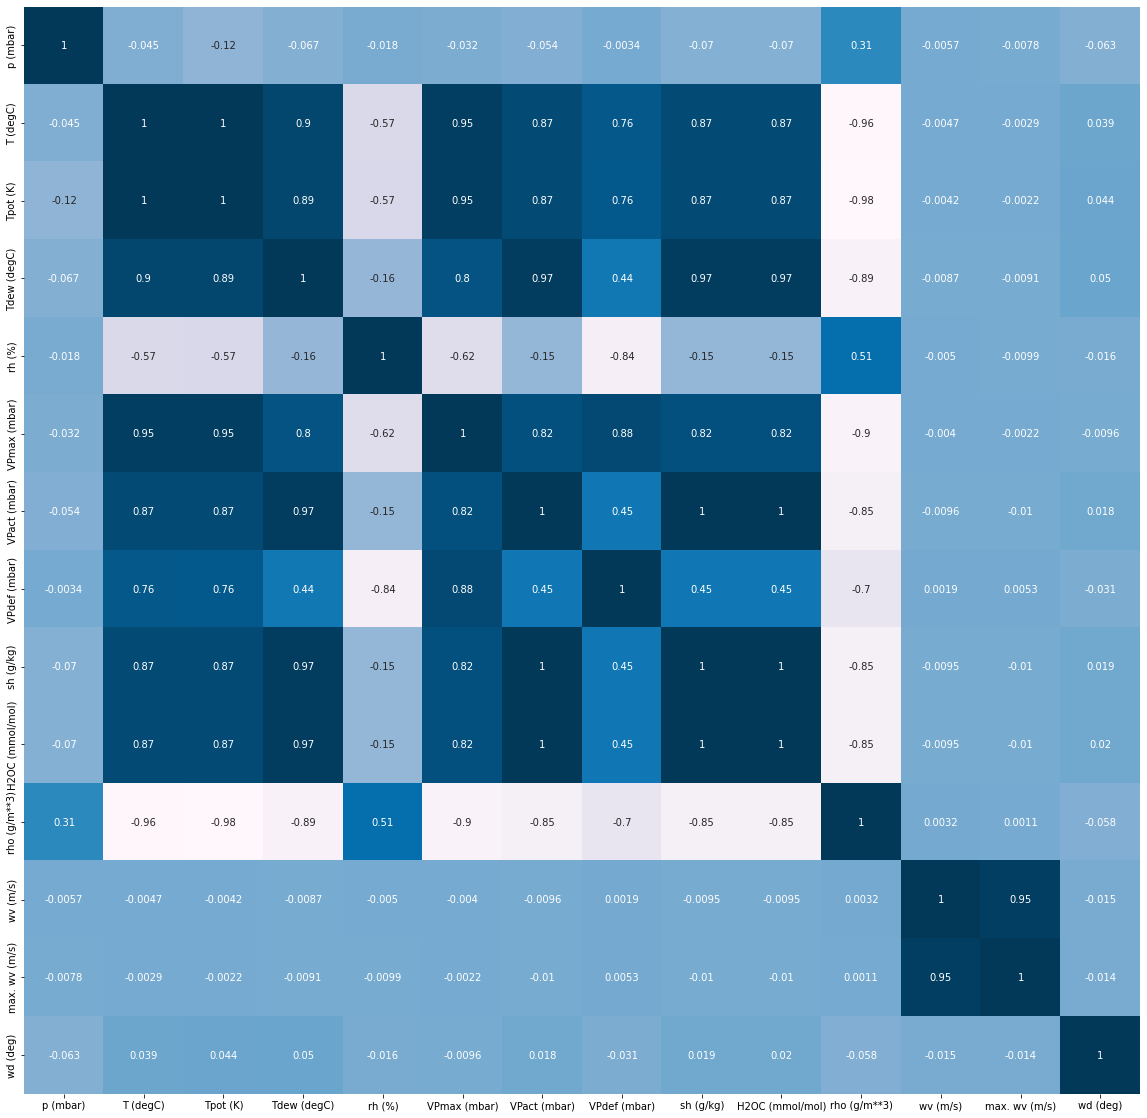

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

def show_correlation_heatmap(dataframe):
    fig, ax = plt.subplots(figsize=(20,20))
    cor = dataframe.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.PuBu, cbar=False)
    ax.set_xticklabels(df.columns[1:])
    ax.set_yticklabels(df.columns[1:])
    plt.show()

show_correlation_heatmap(df)

## Distribution of Wind Data

The last column of the data, `wd (deg)`, gives the wind direction in units of degrees. However, angles in this current format do not make good model inputs. 360° and 0° should be close to each other and wrap around smoothly. Direction shouldn't matter if the wind is not blowing. This will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind vector. Observe how sine and cosine are used to generate wind vector features (`Wx` and `Wy`) in the Transform module below.

## Date Time Feature

Similarly, the `Date Time` column is very useful but not in the current string format. First, you need to convert it to to seconds. Being weather data, it has clear daily and yearly periodicity, and you need to take that into account.

A simple approach to convert it to a usable signal is to again use sine and cosine to convert the time to clear "Time of day" (`Day sin`, `Day cos`) and "Time of year" (`Year sin`, `Year cos`) signals. 

## Transform module

In [17]:
 # Set up constants module filename
 _weather_constants_module_file = '/content/weather_constants.py'

In [18]:
%%writefile {_weather_constants_module_file}

# Selected numeric features to transform
SELECTED_NUMERIC_FEATURES = ['T (degC)', 'VPmax (mbar)', 'VPdef (mbar)', 'sh (g/kg)','rho (g/m**3)']

# Utility function for renaming the feature
def transformed_name(key):
    return key + '_xf'

Writing /content/weather_constants.py


In [19]:
# Set the transform module filename
_weather_transform_module_file = 'weather_transform.py'

In [23]:
!pip install tensorflow_addons==0.12.1

  Using cached tensorflow_addons-0.12.1-cp37-cp37m-manylinux2010_x86_64.whl (703 kB)
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.13.0
    Uninstalling tensorflow-addons-0.13.0:
      Successfully uninstalled tensorflow-addons-0.13.0


In [24]:
%%writefile {_weather_transform_module_file}

import tensorflow as tf
import tensorflow_transform as tft
import datetime

import weather_constants
import tensorflow_addons as tfa
tf.saved_model.SaveOptions(
    namespace_whitelist=['Addons']
)


import math as m

# Features to filter out
FEATURES_TO_REMOVE = ["Tpot (K)", "Tdew (degC)","VPact (mbar)" , "H2OC (mmol/mol)", "max. wv (m/s)"]

# Unpack the contents of the constants module
_SELECTED_NUMERIC_FEATURE_KEYS = weather_constants.SELECTED_NUMERIC_FEATURES
_transformed_name = weather_constants.transformed_name

# Define the transformations
def preprocessing_fn(inputs):
  """Preprocess input columns into transformed columns"""

  outputs = inputs.copy()

  # Filter out redundant features
  for key in FEATURES_TO_REMOVE:
    del outputs[key]

  # Convert degrees to radians
  pi = tf.constant(m.pi)
  wd_rad = inputs['wd (deg)'] * pi/180.0

  # calculate the x and y components 
  outputs['Wx'] = inputs['wv (m/s)'] * tf.math.cos(wd_rad)
  outputs['Wy'] = inputs['wv (m/s)'] * tf.math.sin(wd_rad)

  # Delete `wv (m/s)` after getting the wind vector
  del outputs['wv (m/s)']

  # Get the day and year in seconds
  day = tf.cast(24*60*60, tf.float32)
  year = tf.cast((365.2425)*day, tf.float32)

  # Convert `Date Time` column into timestamps in seconds (using tfa helper function)
  timestamp_s = tfa.text.parse_time(outputs['Date Time'], time_format='%d.%m.%Y %H:%M:%S', output_unit='SECOND')
  timestamp_s = tf.cast(timestamp_s, tf.float32)
  
  # Convert timestamps into periodic signals
  outputs['Day sin'] = tf.math.sin(timestamp_s * (2 * pi / day))
  outputs['Day cos'] = tf.math.cos(timestamp_s * (2 * pi / day))
  outputs['Year sin'] = tf.math.sin(timestamp_s * (2 * pi / year))
  outputs['Year cos'] = tf.math.cos(timestamp_s * (2 * pi / year))

  # Delete unneeded columns
  del outputs['Date Time']
  del outputs['wd (deg)']

  # Final feature list
  FINAL_FEATURE_LIST =  ["p (mbar)",
  "rh (%)", 
  "VPmax (mbar)", 
  "VPdef (mbar)", 
  "sh (g/kg)",
  "rho (g/m**3)",
  "Wx",
  "Wy",
  "Day sin",
  'Day cos',
  'Year sin',
  'Year cos'
  ]



  # Scale selected numeric features
  for key in FINAL_FEATURE_LIST:
      outputs[_transformed_name(key)] = tft.scale_to_0_1(outputs[key])

  return outputs



Overwriting weather_transform.py


In [25]:
# Ignore TF warning messages
import tensorflow_addons as tfa
tf.get_logger().setLevel('ERROR')
tf.saved_model.SaveOptions(
    namespace_whitelist= ['Addons','ParseTime']
)
# Instantiate the Transform component

transform = Transform(
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    module_file=os.path.abspath(_weather_transform_module_file),
    )

# Run the component
context.run(transform)

ExecutionResult(
    component_id: Transform
    execution_id: 6
    outputs:
        transform_graph: Channel(
            type_name: TransformGraph
            artifacts: [Artifact(artifact: id: 8
        type_id: 13
        uri: "pipeline/Transform/transform_graph/6"
        custom_properties {
          key: "name"
          value {
            string_value: "transform_graph"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 13
        name: "TransformGraph"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        transformed_examples: Channel(
            type_name: Examples
            artifacts: [Artifact(artifact: id: 9
        type_id: 5
        uri: "pipeline/Transform/transformed_examples/6"
        properties {
          key: "split_names"
          value {
            string_value: "[\"train\", \"eval\"]"
          }
        }
        custom_properties {
          key: "name"
          value {
            string_value: "transformed_examples"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 5
        name: "Examples"
        properties {
          key: "span"
          value: INT
        }
        properties {
          key: "split_names"
          value: STRING
        }
        properties {
          key: "version"
          value: INT
        }
        )]
            additional_properties: {}
            additional_custom_properties: {}
        )
        updated_analyzer_cache: Channel(
            type_name: TransformCache
            artifacts: [Artifact(artifact: id: 10
        type_id: 14
        uri: "pipeline/Transform/updated_analyzer_cache/6"
        custom_properties {
          key: "name"
          value {
            string_value: "updated_analyzer_cache"
          }
        }
        custom_properties {
          key: "producer_component"
          value {
            string_value: "Transform"
          }
        }
        custom_properties {
          key: "state"
          value {
            string_value: "published"
          }
        }
        state: LIVE
        , artifact_type: id: 14
        name: "TransformCache"
        )]
            additional_properties: {}
            additional_custom_properties: {}
        ))

In [26]:
# Get the URI of the output artifact representing the transformed examples
train_uri = os.path.join(transform.outputs['transformed_examples'].get()[0].uri, 'train')

# Get the list of files in this directory (all compressed TFRecord files)
tfrecord_filenames = [os.path.join(train_uri, name)
                      for name in os.listdir(train_uri)]

# Create a `TFRecordDataset` to read these files
transformed_dataset = tf.data.TFRecordDataset(tfrecord_filenames, compression_type="GZIP")

# Define a helper function to get individual examples
def get_records(dataset, num_records):
    '''Extracts records from the given dataset.
    Args:
        dataset (TFRecordDataset): dataset saved by ExampleGen
        num_records (int): number of records to preview
    '''
    
    # initialize an empty list
    records = []
    
    # Use the `take()` method to specify how many records to get
    for tfrecord in dataset.take(num_records):
        
        # Get the numpy property of the tensor
        serialized_example = tfrecord.numpy()
        
        # Initialize a `tf.train.Example()` to read the serialized data
        example = tf.train.Example()
        
        # Read the example data (output is a protocol buffer message)
        example.ParseFromString(serialized_example)
        
        # convert the protocol bufffer message to a Python dictionary
        example_dict = (MessageToDict(example))
        
        # append to the records list
        records.append(example_dict)
        
    return records

In [27]:
# Get 3 records from the dataset
sample_records_xf = get_records(transformed_dataset, 3)

# Print the output
pp.pprint(sample_records_xf)

[{'features': {'feature': {'Day cos': {'floatList': {'value': [0.9988126]}},
                           'Day cos_xf': {'floatList': {'value': [0.99940634]}},
                           'Day sin': {'floatList': {'value': [0.048717435]}},
                           'Day sin_xf': {'floatList': {'value': [0.52435875]}},
                           'T (degC)': {'floatList': {'value': [-8.02]}},
                           'VPdef (mbar)': {'floatList': {'value': [0.22]}},
                           'VPdef (mbar)_xf': {'floatList': {'value': [0.0047815694]}},
                           'VPmax (mbar)': {'floatList': {'value': [3.33]}},
                           'VPmax (mbar)_xf': {'floatList': {'value': [0.03788602]}},
                           'Wx': {'floatList': {'value': [-0.9119556]}},
                           'Wx_xf': {'floatList': {'value': [0.999062]}},
                           'Wy': {'floatList': {'value': [0.47878695]}},
                           'Wy_xf': {'floatList': {'value': 